In [1]:
import requests
import pandas as pd
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", None)  
pd.set_option("display.max_columns", None) 
pd.set_option("display.width", 1000) 

In [2]:
rp_url = "data/FantasyPros_2025_Projections_RP.csv"
sp_url = "data/FantasyPros_2025_Projections_SP.csv"
cats = ["Player", "Team", "Positions","ERA", "WHIP", "K", "QS", "SV+HD" ]
df1 = pd.read_csv(sp_url)
df2 = pd.read_csv(rp_url)
df1["SV+HD"] = 0
df1 = df1[cats]
df1["primary_position"] = "SP"

df1 = df1.head(100)

df2["SV+HD"] = df2["SV"] + df2["HD"]
df2["QS"] = 0
df2 = df2[cats]
df2["primary_position"] = "RP"

df2 = df2.head(50)


In [3]:
def calculate_data_cats(df, cats):
    
    data_cats = []
    for cat in cats:
        if cat=="WHIP" or cat=="ERA":
            x = -1*df[cat]
            
        else:
            x = df[cat]
        mean = np.mean(x)
        std = np.std(x)
        z_score = (x - mean) / std

        data_cat = f"{cat}_zscore"
        df[data_cat] = pd.Series(z_score)


sp_cats = ["QS"]
calculate_data_cats(df1, sp_cats)
df1["SV+HD_zscore"] = 0

rp_cats = ["SV+HD"]
calculate_data_cats(df2, rp_cats)

df2["QS_zscore"] = 0

df = pd.concat([df1, df2])
df = df.drop_duplicates(subset=["Player", "Team"], keep="first")

cats = ["ERA", "WHIP", "K"]
calculate_data_cats(df, cats)

del df1
del df2

In [4]:
adp_url = "data/FantasyPros_2025_Overall_MLB_ADP_Rankings.csv"

df_adp = pd.read_csv(adp_url)
df_adp.rename(columns={"AVG": "adp_avg"}, inplace=True)

df_adp["adp_sd"] = df_adp.apply(lambda x: np.std(x[["Yahoo", "RTS", "NFBC", "FT"]]), axis=1)

df_adp = df_adp.drop(["Rank","Team", "Positions", "Yahoo", "RTS", "NFBC", "FT"],axis=1)


In [5]:
df = df.merge(df_adp, on="Player", how="inner") 

In [6]:
def get_ap(row):
    if row["primary_position"] == "SP":
        return np.mean(row[['ERA_zscore', 'WHIP_zscore', 'K_zscore', 'QS_zscore', ]])
    elif row["primary_position"]:

        return np.mean(row[['ERA_zscore', 'WHIP_zscore', 'K_zscore', 'SV+HD_zscore']])
        

col = 'average_zscore'
data_cats=['ERA_zscore', 'WHIP_zscore', 'K_zscore', 'QS_zscore', 'SV+HD_zscore']
df[col] = df.apply(get_ap, axis=1)
data_cats.append(col)

In [8]:
df['adp_avg'] = pd.to_numeric(df['adp_avg'], errors='coerce')

df['adp_avg'] = df['adp_avg'].fillna(0)  # Or use dropna() if you prefer to remove rows with NaN

df['round'] = (df['adp_avg'] // 12 + 1).astype(int)

df['round'] = df['round'].clip(upper=24)

In [9]:
round_by_round = df.groupby(['round', "primary_position"])['average_zscore'].mean().reset_index()



,round,primary_position,average_zscore
0,1,SP,0.113487
1,2,SP,1.755437
2,3,SP,1.132894
3,4,RP,1.143450
4,4,SP,1.005996
5,5,SP,0.820608
6,6,RP,0.759215
7,6,SP,0.719919
8,7,RP,0.955006
9,7,SP,0.532719


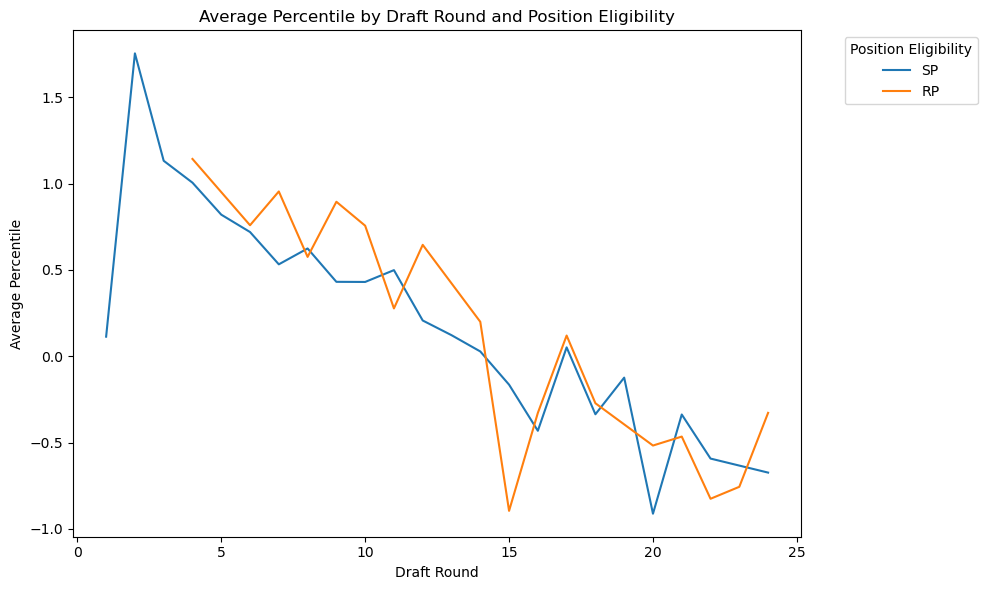

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=round_by_round, x='round', y='average_zscore', hue='primary_position')

plt.title('Average Percentile by Draft Round and Position Eligibility')
plt.xlabel('Draft Round')
plt.ylabel('Average Percentile')
plt.legend(title='Position Eligibility', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
def get_rel_percent(row):
    position = row["primary_position"]
    
    r = round_by_round[(round_by_round["round"] == row["round"]) &
                       (round_by_round["primary_position"] == position)]["average_zscore"]
    
 
    ans = 0
    
    try:
        ans = (row["average_zscore"] - r).iloc[0]
        return ans
    except:
        print(row)
        return None
        
        
    
    
df['relative_zscore'] = df.apply(get_rel_percent,axis=1)

In [12]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Prevent line breaks
df = df.sort_values(by='relative_zscore', ascending=False)
# Drop rows with NaN in 'relative_percentile' before ranking
df = df.dropna(subset=['relative_zscore'])

# Now, apply the rank
df["rp_rank"] = df["relative_zscore"].rank(method="dense", ascending=False).astype(int)
df["p_rank"] = df["average_zscore"].rank(method="dense", ascending=False).astype(int)



In [13]:
from IPython.display import display

display_cats = ["rp_rank", "p_rank", "Player", "Positions","ERA_zscore",
                "WHIP_zscore",
                "K_zscore",
                "QS_zscore",
                "SV+HD_zscore", "relative_zscore","adp_avg"]


display(df[df["adp_avg"] < 120][display_cats])

,rp_rank,p_rank,Player,Positions,ERA_zscore,WHIP_zscore,K_zscore,QS_zscore,SV+HD_zscore,relative_zscore,adp_avg
15,5,6,Jacob deGrom,SP,1.732363,3.094186,0.585762,0.019679,0.000000,0.537390,55.5
5,9,3,Chris Sale,SP,1.348313,1.391041,1.672687,1.331584,0.000000,0.429910,36.5
32,19,18,Sonny Gray,SP,0.364185,0.539469,1.162497,1.003608,0.000000,0.336824,111.0
0,23,1,Tarik Skubal,SP,1.924388,2.242614,1.983237,1.987537,0.000000,0.279007,14.3
3,27,5,Logan Gilbert,SP,0.700229,1.634348,1.539594,1.659561,0.000000,0.250538,29.3
20,28,13,Tyler Glasnow,SP,0.964263,1.634348,0.874129,0.019679,0.000000,0.248461,91.3
29,32,29,Joe Ryan,SP,-0.139880,1.391041,0.985040,0.347655,0.000000,0.215348,110.3
104,33,8,Mason Miller,RP,2.308438,2.364267,-0.745167,0.000000,0.742465,0.212495,75.0
17,34,15,Logan Webb,SP,0.700229,0.174509,0.807583,1.659561,0.000000,0.210826,88.3
23,52,36,Tanner Bibee,SP,0.028142,0.417816,0.985040,0.675631,0.000000,0.095342,96.3


In [18]:
from IPython.display import display

display_cats = ["rp_rank", "p_rank","adp_avg","Player", "Positions", "ERA_zscore",
                "WHIP_zscore",
                "K_zscore",
                "QS_zscore",
                "SV+HD_zscore", "relative_zscore", "average_zscore",]

display(df.sort_values(by='average_zscore', ascending=False)[display_cats])


,rp_rank,p_rank,adp_avg,Player,Positions,ERA_zscore,WHIP_zscore,K_zscore,QS_zscore,SV+HD_zscore,relative_zscore,average_zscore
0,23,1,14.3,Tarik Skubal,SP,1.924388,2.242614,1.983237,1.987537,0.000000,0.279007,2.034444
1,63,2,12.8,Paul Skenes,SP,2.044404,1.756001,1.761415,1.659561,0.000000,0.049908,1.805345
5,9,3,36.5,Chris Sale,SP,1.348313,1.391041,1.672687,1.331584,0.000000,0.429910,1.435906
2,120,4,21.0,Zack Wheeler,SP,0.916257,1.391041,1.739233,1.659561,0.000000,-0.328914,1.426523
3,27,5,29.3,Logan Gilbert,SP,0.700229,1.634348,1.539594,1.659561,0.000000,0.250538,1.383433
15,5,6,55.5,Jacob deGrom,SP,1.732363,3.094186,0.585762,0.019679,0.000000,0.537390,1.357997
4,61,7,35.8,Garrett Crochet,SP,1.300307,1.269388,1.517412,0.675631,0.000000,0.057790,1.190685
104,33,8,75.0,Mason Miller,RP,2.308438,2.364267,-0.745167,0.000000,0.742465,0.212495,1.167501
100,74,9,46.8,Emmanuel Clase,RP,2.524466,2.120961,-1.432814,0.000000,1.361186,0.000000,1.143450
103,59,10,75.0,Edwin Diaz,RP,1.780369,1.756001,-0.833896,0.000000,1.361186,0.060909,1.015915
